In [0]:
import os, sys



In [0]:
from google.colab import drive

In [5]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
os.chdir("/content/drive/My Drive/MACE")
sys.path.append("/content/drive/My Drive/MACE")

In [7]:
!pwd

/content/drive/My Drive/MACE


In [0]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

from matplotlib import pyplot as plt


True
True


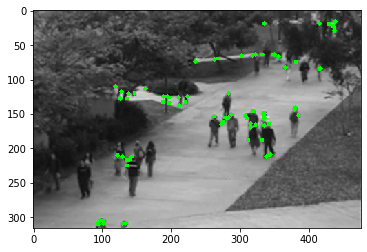

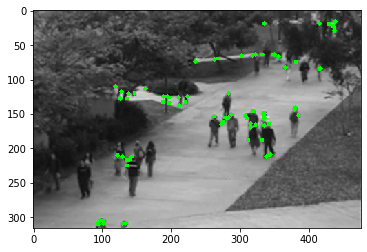

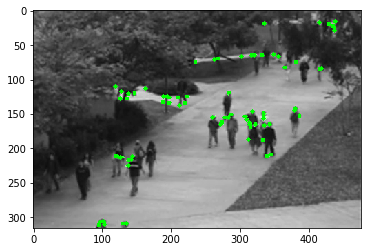

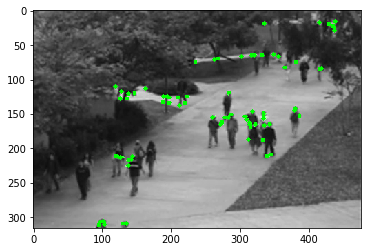

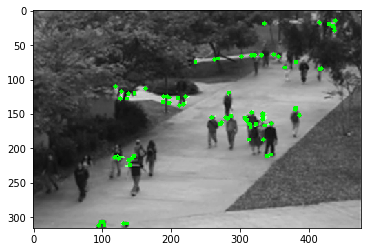

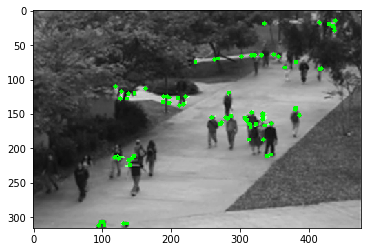

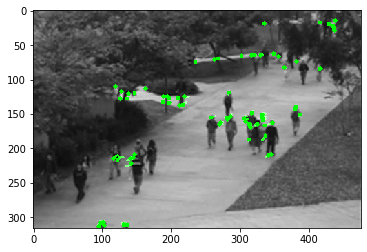

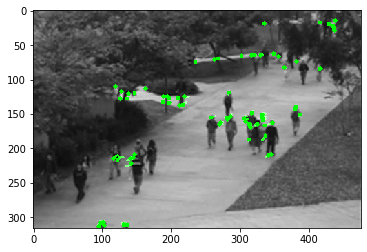

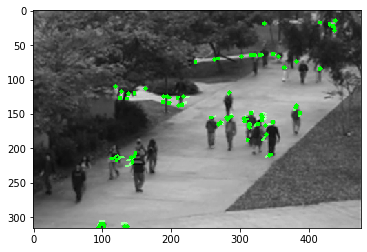

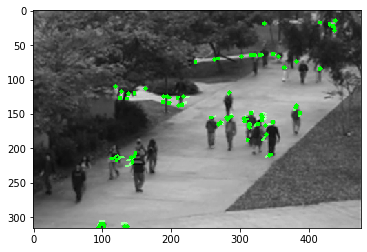

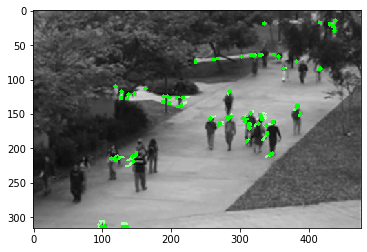

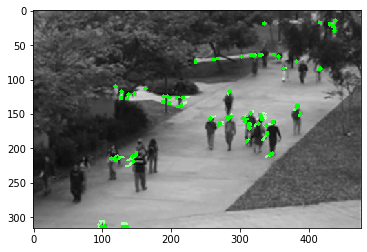

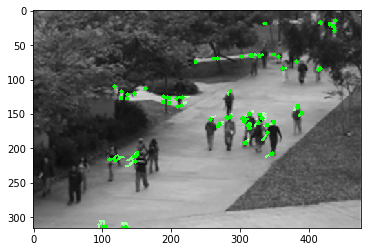

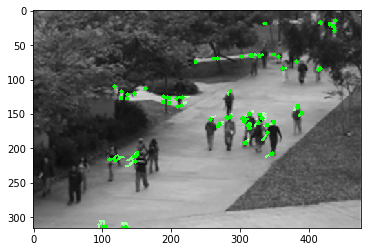

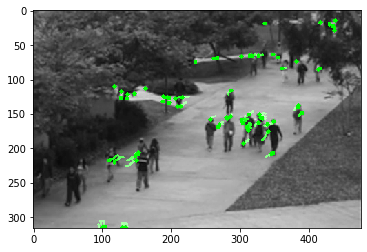

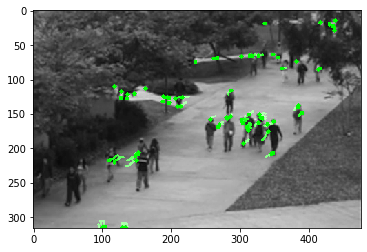

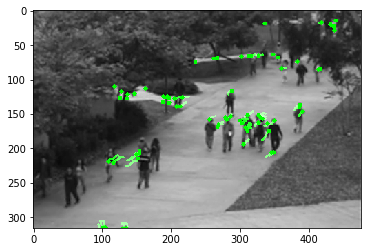

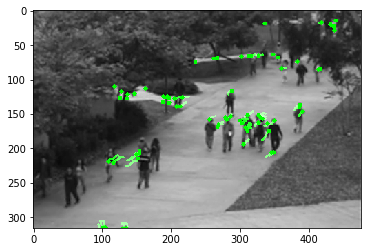

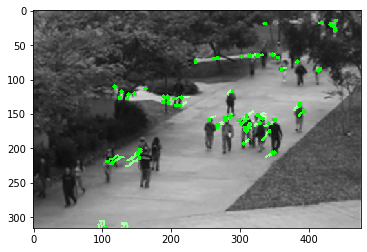

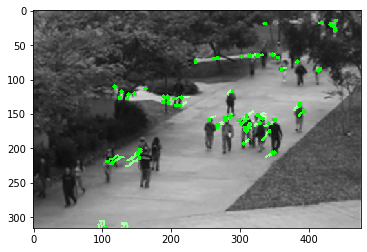

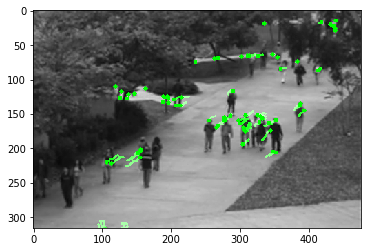

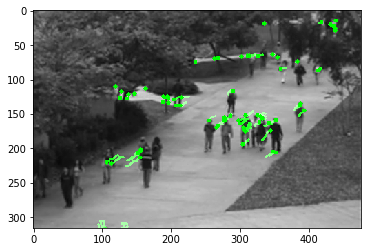

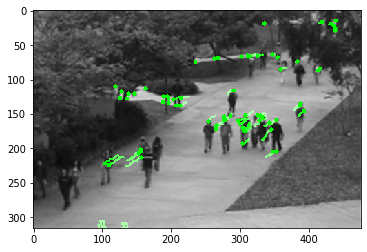

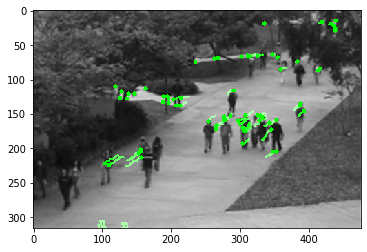

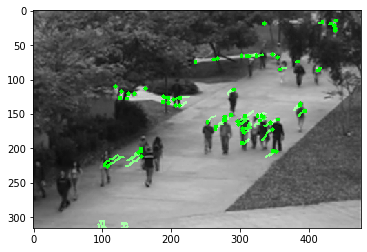

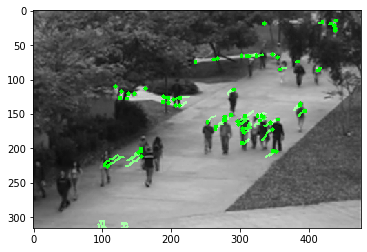

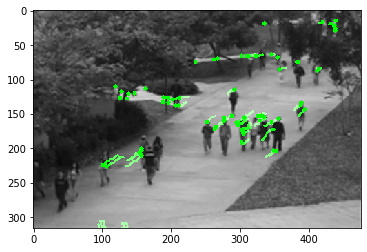

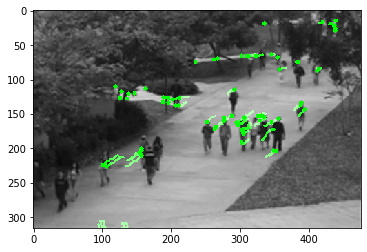

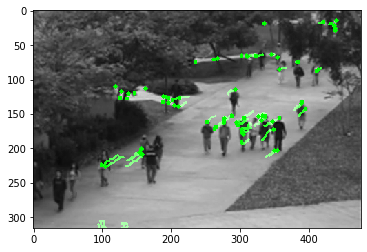

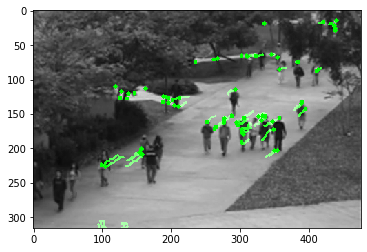

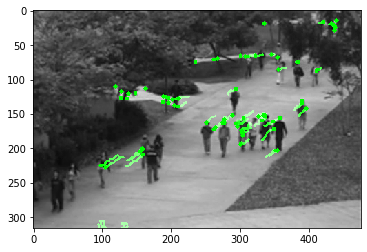

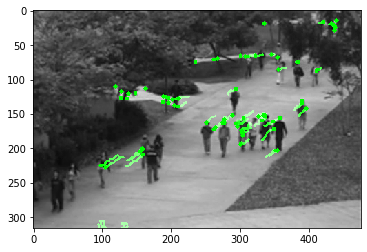

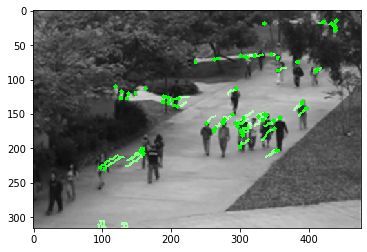

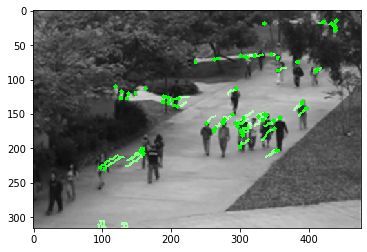

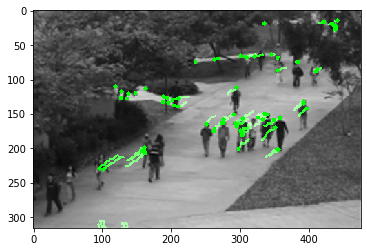

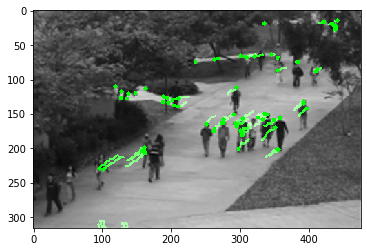

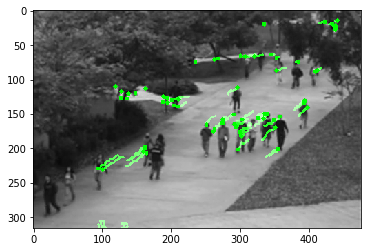

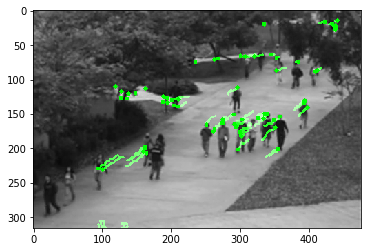

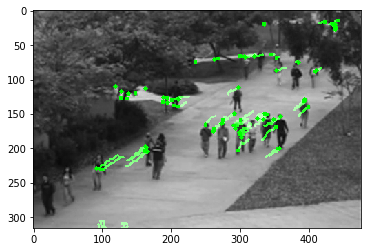

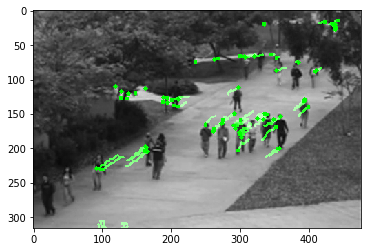

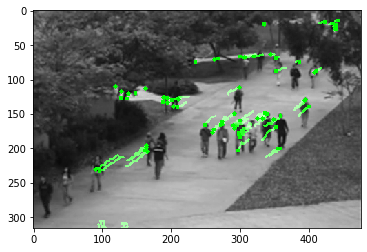

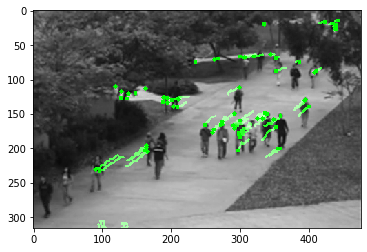

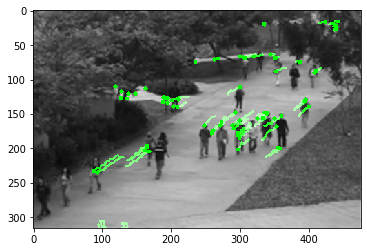

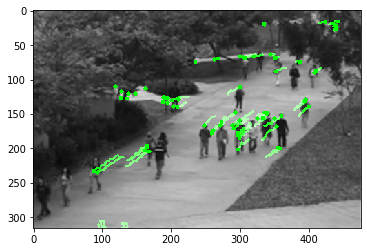

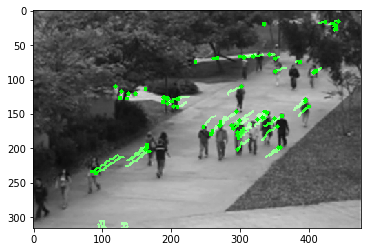

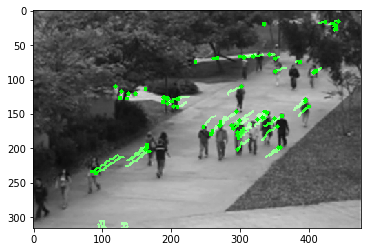

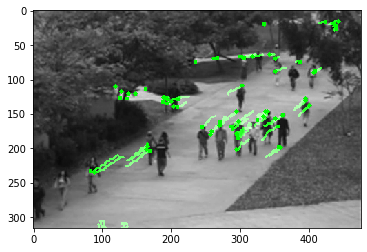

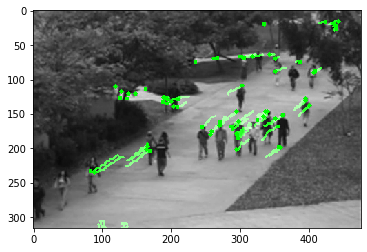

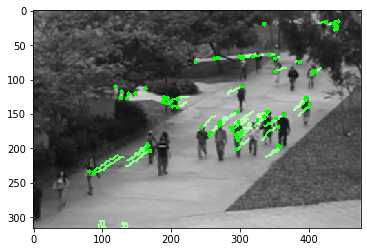

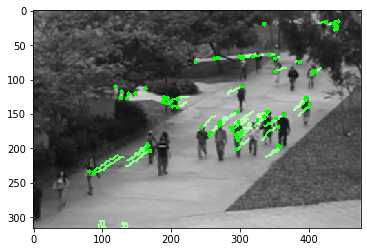

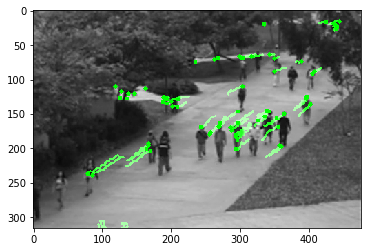

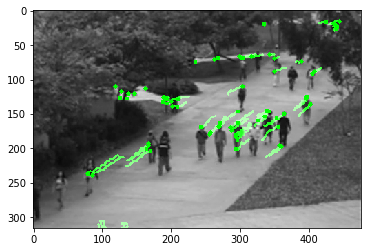

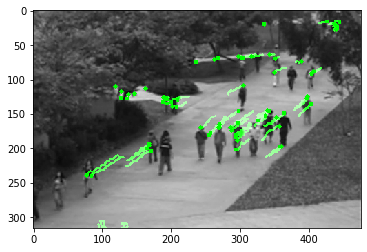

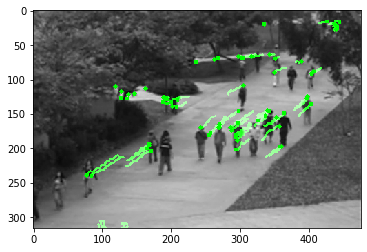

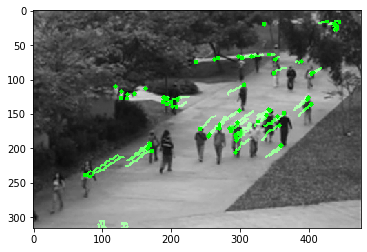

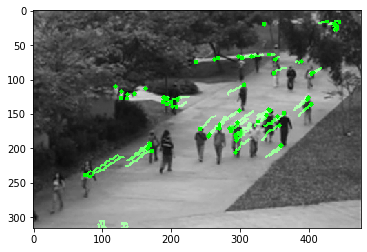

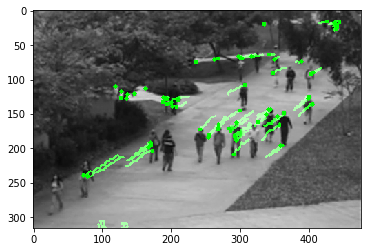

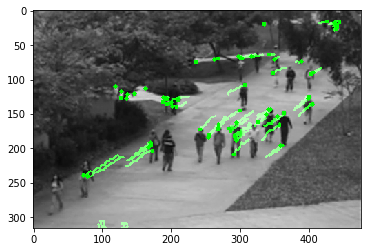

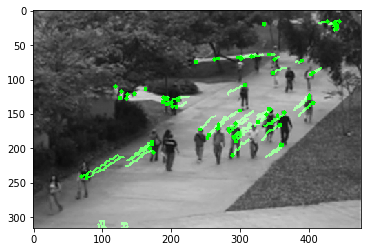

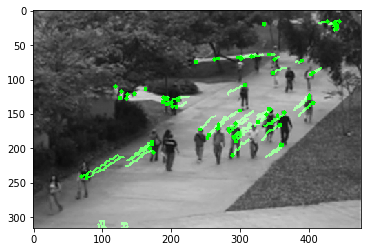

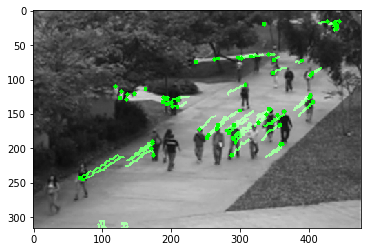

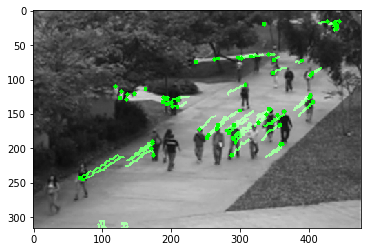

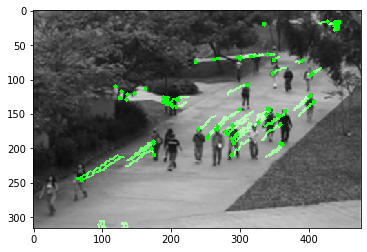

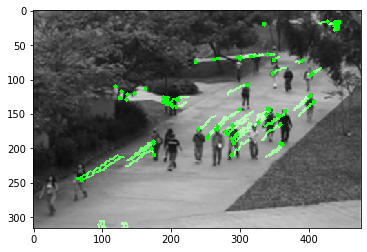

In [0]:
import cv2 as cv
import numpy as np

# Parameters for Shi-Tomasi corner detection
feature_params = dict(maxCorners = 300, qualityLevel = 0.2, minDistance = 2, blockSize = 7)
# Parameters for Lucas-Kanade optical flow
lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# The video feed is read in as a VideoCapture object
cap = cv.VideoCapture("output2.mp4")
# Variable for color to draw optical flow track
color = (0, 255, 0)
# ret = a boolean return value from getting the frame, first_frame = the first frame in the entire video sequence
ret, first_frame = cap.read()
print(ret)
# Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally expensive
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
# Finds the strongest corners in the first frame by Shi-Tomasi method - we will track the optical flow for these corners
# https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html#goodfeaturestotrack
prev = cv.goodFeaturesToTrack(prev_gray, mask = None, **feature_params)
# Creates an image filled with zero intensities with the same dimensions as the frame - for later drawing purposes
mask = np.zeros_like(first_frame)

while(cap.isOpened()):
    # ret = a boolean return value from getting the frame, frame = the current frame being projected in the video
    ret, frame = cap.read()
    # Converts each frame to grayscale - we previously only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calculates sparse optical flow by Lucas-Kanade method
    # https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowpyrlk
    next, status, error = cv.calcOpticalFlowPyrLK(prev_gray, gray, prev, None, **lk_params)
    # Selects good feature points for previous position
    good_old = prev[status == 1]
    # Selects good feature points for next position
    good_new = next[status == 1]
    # Draws the optical flow tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        # Returns a contiguous flattened array as (x, y) coordinates for new point
        a, b = new.ravel()
        # Returns a contiguous flattened array as (x, y) coordinates for old point
        c, d = old.ravel()
        # Draws line between new and old position with green color and 2 thickness
        mask = cv.line(mask, (a, b), (c, d), color, 2)
        # Draws filled circle (thickness of -1) at new position with green color and radius of 3
        frame = cv.circle(frame, (a, b), 3, color, -1)
    # Overlays the optical flow tracks on the original frame
    output = cv.add(frame, mask)
    # Updates previous frame
    prev_gray = gray.copy()
    # Updates previous good feature points
    prev = good_new.reshape(-1, 1, 2)
    # Opens a new window and displays the output frame
    #cv.imshow("sparse optical flow", output)
    plt.imshow(output)
    plt.show()
    # Frames are read by intervals of 10 milliseconds. The programs breaks out of the while loop when the user presses the 'q' key
    if cv.waitKey(10) & 0xFF == ord('q'):
        break
# The following frees up resources and closes all windows
cap.release()
cv.destroyAllWindows()